# Modelling

## Import Train, Test Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
dirname = '../data/processed/'
X_train = pd.read_csv(dirname + 'X_train_trimmed.csv', sep=',')
X_test = pd.read_csv(dirname + 'X_test_trimmed.csv', sep=',')
y_train = pd.read_csv(dirname + 'y_train_trimmed.csv', sep=',')
y_test = pd.read_csv(dirname + 'y_test_trimmed.csv', sep=',')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price_reduced_amount         4232 non-null   float64
 1   year_built                   4232 non-null   int64  
 2   lot_sqft                     4232 non-null   float64
 3   sqft                         4232 non-null   float64
 4   baths                        4232 non-null   int64  
 5   garage                       4232 non-null   int64  
 6   stories                      4232 non-null   int64  
 7   beds                         4232 non-null   int64  
 8   central_air                  4232 non-null   int64  
 9   central_heat                 4232 non-null   int64  
 10  fireplace                    4232 non-null   int64  
 11  rental_property              4232 non-null   int64  
 12  energy_efficient             4232 non-null   int64  
 13  community_security

## Multivariate EDA

In [4]:
numeric_features = [
    'price_reduced_amount', 'year_built', 'lot_sqft', 'sqft',
    'baths', 'garage', 'stories', 'beds', 'median_by_pc'
]

boolean_features = X_train.drop(columns=numeric_features).columns.to_list()

### Correlations

To get a sense of what might be the most important features, we plot some correlation matrix heat maps. Between sold_price and numeric features, we use Pearson correlation coefficients. Between sold_price and categorical (Boolean, at this stage) features, we use Kendall correlation coefficients.

<Axes: >

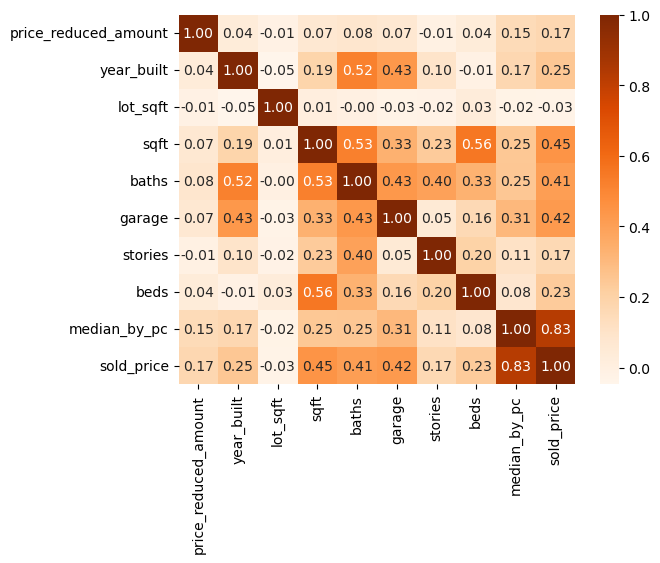

In [5]:
corr_matrix_pearson = X_train.join(y_train)\
    .drop(columns=boolean_features)\
    .corr(method='pearson')

sns.heatmap(corr_matrix_pearson, cmap='Oranges', annot=True, fmt='.2f')

<Axes: >

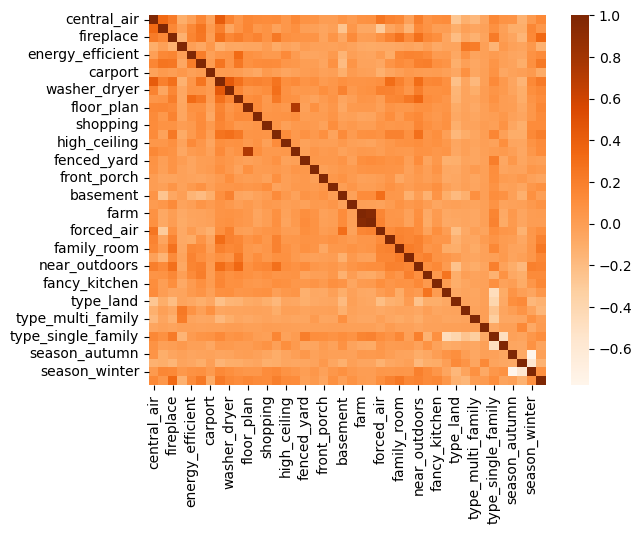

In [6]:
corr_matrix_kendall = X_train.join(y_train)\
    .drop(columns=numeric_features)\
    .corr(method='kendall')

sns.heatmap(corr_matrix_kendall, cmap='Oranges')

Combining the above results, we get a sense of which features are likely to be the most significant.

In [7]:
corr_ser = pd.concat(
    (corr_matrix_pearson['sold_price'].drop('sold_price'),
    corr_matrix_kendall['sold_price'].drop('sold_price')),
    join='outer'
)
corr_ser.sort_values(ascending=False)

median_by_pc                   0.826870
sqft                           0.448502
garage                         0.423450
baths                          0.408667
fireplace                      0.331576
year_built                     0.250951
family_room                    0.239274
community_security_features    0.236513
beds                           0.234567
dishwasher                     0.228696
hardwood_floors                0.199620
dining_room                    0.178284
near_outdoors                  0.175564
price_reduced_amount           0.173290
stories                        0.165147
view                           0.152270
floor_plan                     0.149598
fancy_kitchen                  0.143989
washer_dryer                   0.141104
central_air                    0.137249
energy_efficient               0.125463
near_rec_facilities            0.123830
ensuite                        0.122296
high_ceiling                   0.121878
laundry_room                   0.119505


### Scatter Plots

We pick out the top few features that correlate most strongly with 'sold_price' and construct scatter plots. 

In [8]:
threshold = 0.2
significant_features =\
    corr_ser[corr_ser.apply(np.abs) >= threshold].index.to_list()

significant_features

['year_built',
 'sqft',
 'baths',
 'garage',
 'beds',
 'median_by_pc',
 'fireplace',
 'community_security_features',
 'dishwasher',
 'family_room']

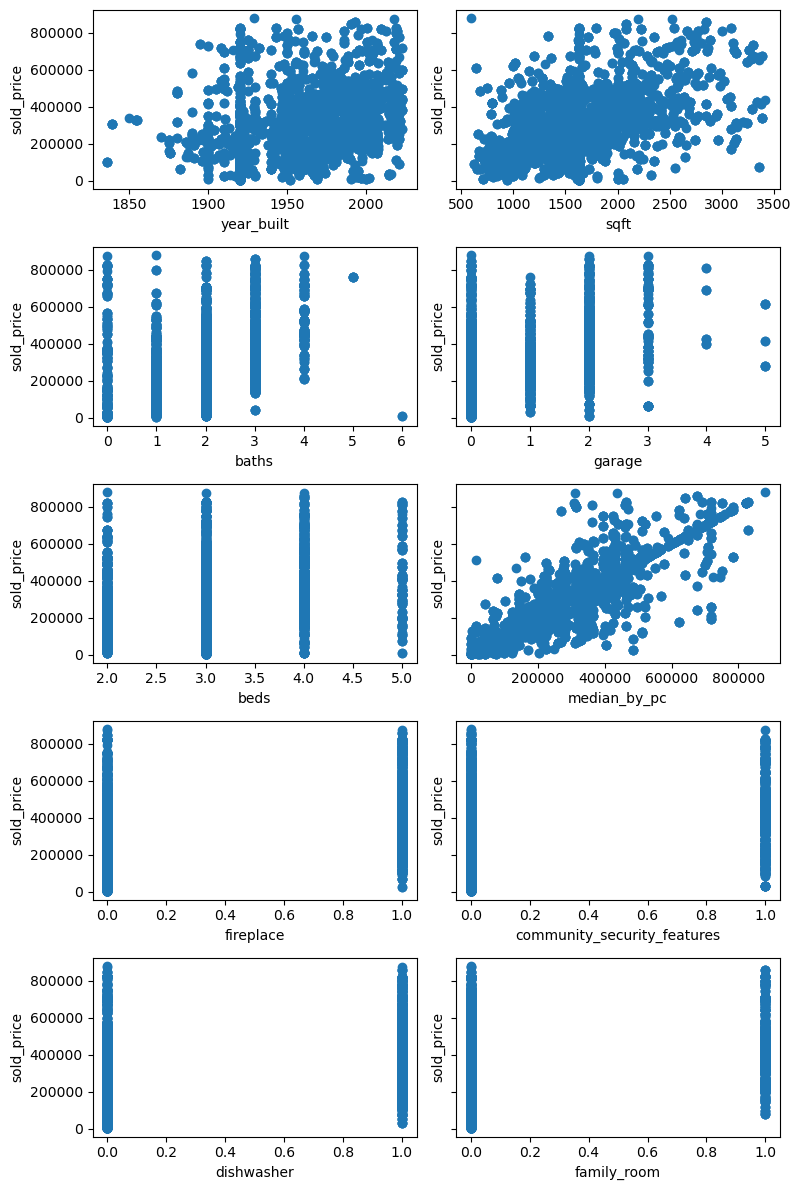

In [9]:
nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(8, 12), sharey=True)
for feature in significant_features:
    idx = significant_features.index(feature)
    row = idx // ncols
    col = idx % ncols
    axes[row, col].scatter(X_train[feature], y_train)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('sold_price')
fig.tight_layout()

## Machine-Learning Modelling

### sklearn Imports

In [10]:
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #, PolynomialFeatures
# from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, Lasso

from utils import print_scores, make_coef_dict

### Scale the Data

In [11]:
scaler = MinMaxScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)

### Linear Regression

In [12]:
regressor = Ridge(alpha=0)
regressor.fit(X_train_tr, y_train)

y_train_pred = regressor.predict(X_train_tr)
y_test_pred = regressor.predict(X_test_tr)

print_scores(y_train, y_train_pred, y_test, y_test_pred)

make_coef_dict(X_train, regressor.coef_[0])

RMSE train: 84511.8694924404
RMSE test: 82051.68937397089
MAE train: 243.19612049655453
MAE test: 245.19596004732503
R**2 train: 0.8887416312651045
R**2 test: 0.8966441910538524


In [13]:
type(regressor.coef_)

numpy.ndarray

In [14]:
d = {}
for (feature, coefficient) in zip(X_train.columns.to_list(), regressor.coef_[0]):
    d[feature] = coefficient
print(d['beds'])

24137.596592965452


### Ridge Regression

In [15]:
regressor = Ridge()
regressor.fit(X_train_tr, y_train)

y_train_pred = regressor.predict(X_train_tr)
y_test_pred = regressor.predict(X_test_tr)

print_scores(y_train, y_train_pred, y_test, y_test_pred)

make_coef_dict(X_train, regressor.coef_[0])

RMSE train: 84315.43366814253
RMSE test: 82391.02097283554
MAE train: 242.8157016686675
MAE test: 245.67258945548656
R**2 train: 0.889290405380387
R**2 test: 0.8957377197115197


### Lasso Regression

In [16]:
regressor = Lasso()
regressor.fit(X_train_tr, y_train)

y_train_pred = regressor.predict(X_train_tr)
y_test_pred = regressor.predict(X_test_tr)

print_scores(y_train, y_train_pred, y_test, y_test_pred)

make_coef_dict(X_train, regressor.coef_[0])

RMSE train: 84305.77803643236
RMSE test: 82380.9237125236
MAE train: 242.59838971846457
MAE test: 245.49018637847237
R**2 train: 0.8893173382446733
R**2 test: 0.8957647602357941


TypeError: 'numpy.float64' object is not iterable